# Анализ отзывов на банки

В данных представлены отзывы на банки с сайта [banki.ru](https://www.banki.ru/)
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

Будет плюсом визуализация результатов работы модели (ответ на вопрос: почему построенная модель считает этот отзыв положительным или отрицательным?)

In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
pip install catboost

In [ ]:
pip install shap

## 1. Предобработка данных

In [ ]:
import re
import nltk
import pandas as pd
import seaborn as sns
import shap
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from nltk.corpus import stopwords 
from sklearn.model_selection import GridSearchCV
from pandas_profiling import ProfileReport
from sklearn import metrics
from sklearn.metrics import classification_report,roc_auc_score,roc_curve
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
shap.initjs()

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

In [ ]:
#Считаем данные
df = pd.read_csv(r'C:\Users\pyora\Desktop\data\parsed_reviews3.csv')

In [ ]:
#Посмотрим первые 5 строк
df.head()

body  \
0  &lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...   
1  &lt;p&gt;При возврате просроченной задолженнос...   
2  &lt;p&gt;07.09.22 ю была оформлена кредитная к...   
3  &lt;p&gt;Новый год начинается с приятностей)&l...   
4  &lt;p&gt;Увидела на сайте Газпромбанка акцию с...   

                                               title  rating      bank_name  \
0                             Заблокировали средства       1      Еком Банк   
1                 Возврат просроченной задолженномти       1  Тинькофф Банк   
2  Ошибочное начисление комиссии, затягивание про...       1  Банк Открытие   
3                    Клиентоориентиванность 10 из 10       5  Тинькофф Банк   
4  Как Газпромбанк обманывает клиентов с акционны...       1    Газпромбанк   

                  date  
0  2023-01-03 12:46:11  
1  2023-01-03 12:31:46  
2  2023-01-03 12:23:11  
3  2023-01-03 12:16:07  
4  2023-01-03 12:12:36

In [ ]:
#Посмотрим типы столбцов и количество строк в столцах
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92735 entries, 0 to 92734
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       92735 non-null  object
 1   title      92735 non-null  object
 2   rating     92735 non-null  int64 
 3   bank_name  92735 non-null  object
 4   date       92735 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.5+ MB


In [ ]:
#Выделим нужные символы
pattern = r'([^а-яА-ЯёЁ])'

In [ ]:
#Удалим из строк столбца body лишние символы
df['body'] = df['body'].map(lambda x:re.sub(pattern,' ',x))

In [ ]:
#Удалим из строк столбца title лишние символы
df['title'] = df['title'].map(lambda x:re.sub(pattern,' ',x))

In [ ]:
#Удалим лишние пробелы
for i in range(0, len(df['body'])):
  df['body'][i] = ' '.join(df['body'][i].split())
  df['title'][i] = ' '.join(df['title'][i].split())

In [ ]:
#Посмотрим, есть ли пустые отзывы
nulled = df[(df['body'] == '') | (df['body'] == ' ')]
nulled

body                                 title  rating         bank_name  \
2935                                                   3           Агророс   
2936                                                   4           Агророс   
2962                                                   3           Агророс   
3118                                    Уааааааа       4          Авангард   
20287       Хороший банк пользуюсь не первый год       5  Хоум Кредит Банк   
41144                                      Бонус       5     Тинькофф Банк   

                      date  
2935   2022-12-27 22:42:52  
2936   2022-12-27 22:39:55  
2962   2022-12-27 21:55:50  
3118   2022-12-27 17:21:32  
20287  2022-12-09 10:05:25  
41144  2022-11-14 21:38:00

In [ ]:
#Переведем столбцы в нужный формат
df['date'] = pd.to_datetime(df['date'])

In [ ]:
#Приведем все столбцы к нижнему регистру
df['bank_name'] = df['bank_name'].str.lower()
df['body'] = df['body'].str.lower()
df['title'] = df['title'].str.lower()

In [ ]:
dupl = df[df['body'].duplicated('last')]
print('Количество дублированных отзывов:', len(dupl))

Количество дублированных отзывов: 1561


In [ ]:
#Удалим дублированные отзывы
data = df.drop(dupl.index)

## 2. EDA

In [ ]:
profile = ProfileReport(data)

In [ ]:
#EDA данных
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

После предобработки в данных нет пропусков,нет дупликатов, body 90935 уникальных строк, title 49336 уникальных значений, bank_name 156 уникальных значений, пропусков нет

### топ-15 банков по числу отзывов

In [ ]:
top_15 = data['bank_name'].value_counts().head(15).reset_index().rename(columns={'index': 'bank_name', 'bank_name': 'cnt'})
top_15

bank_name    cnt
0                             тинькофф банк  43473
1                          хоум кредит банк   9271
2                                совкомбанк   6082
3                                       втб   3805
4                                  сбербанк   3482
5                                альфа-банк   3361
6                            россельхозбанк   3053
7                             банк открытие   1888
8                                  мтс банк   1542
9                                модульбанк   1448
10                              газпромбанк   1312
11                московский кредитный банк   1249
12              азиатско-тихоокеанский банк    999
13  уральский банк реконструкции и развития    744
14                         ренессанс кредит    686

In [ ]:
sns.set(rc={"figure.figsize":(20, 10)})

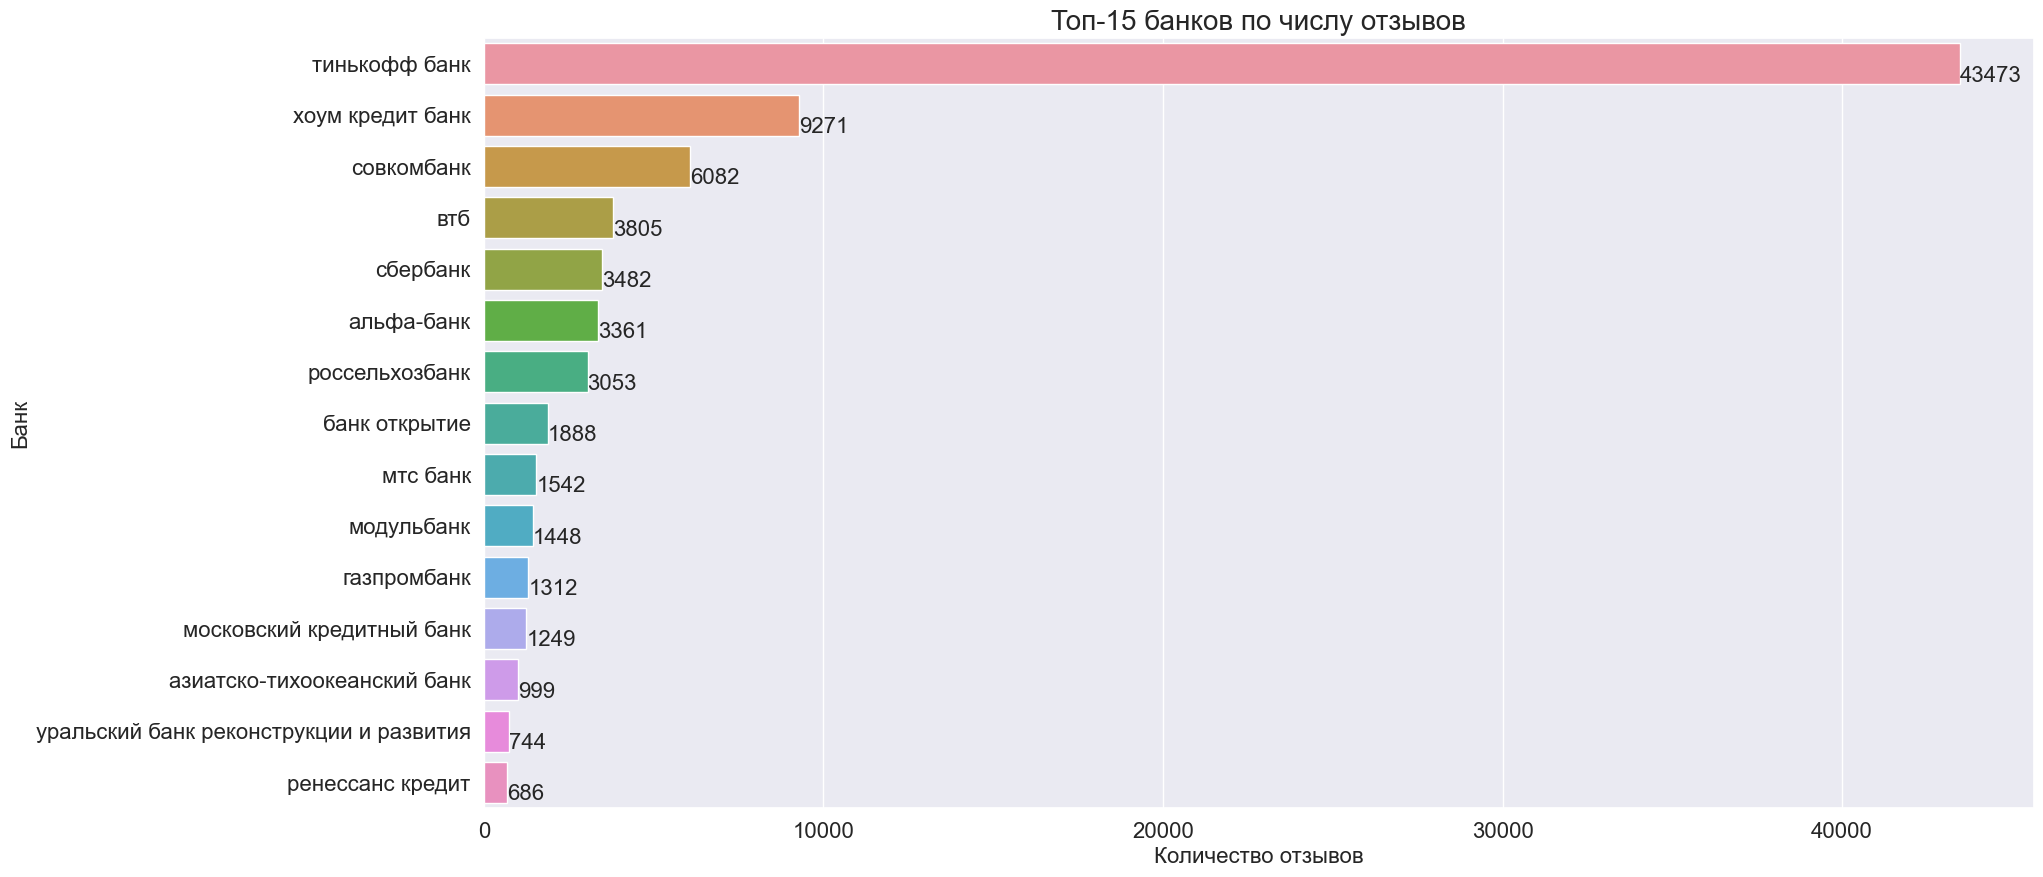

In [ ]:
ax = sns.barplot(y = top_15['bank_name'], 
             x = top_15['cnt'], orient = 'h')
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_x() + p.get_width()+2, p.get_y() + p.get_height()+0.1), 
                ha = 'left', va = 'center', xytext = (0, 10), textcoords = 'offset points', size = 16)
plt.title('Топ-15 банков по числу отзывов', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Количество отзывов', fontsize = 16)
plt.ylabel('Банк', fontsize = 16);

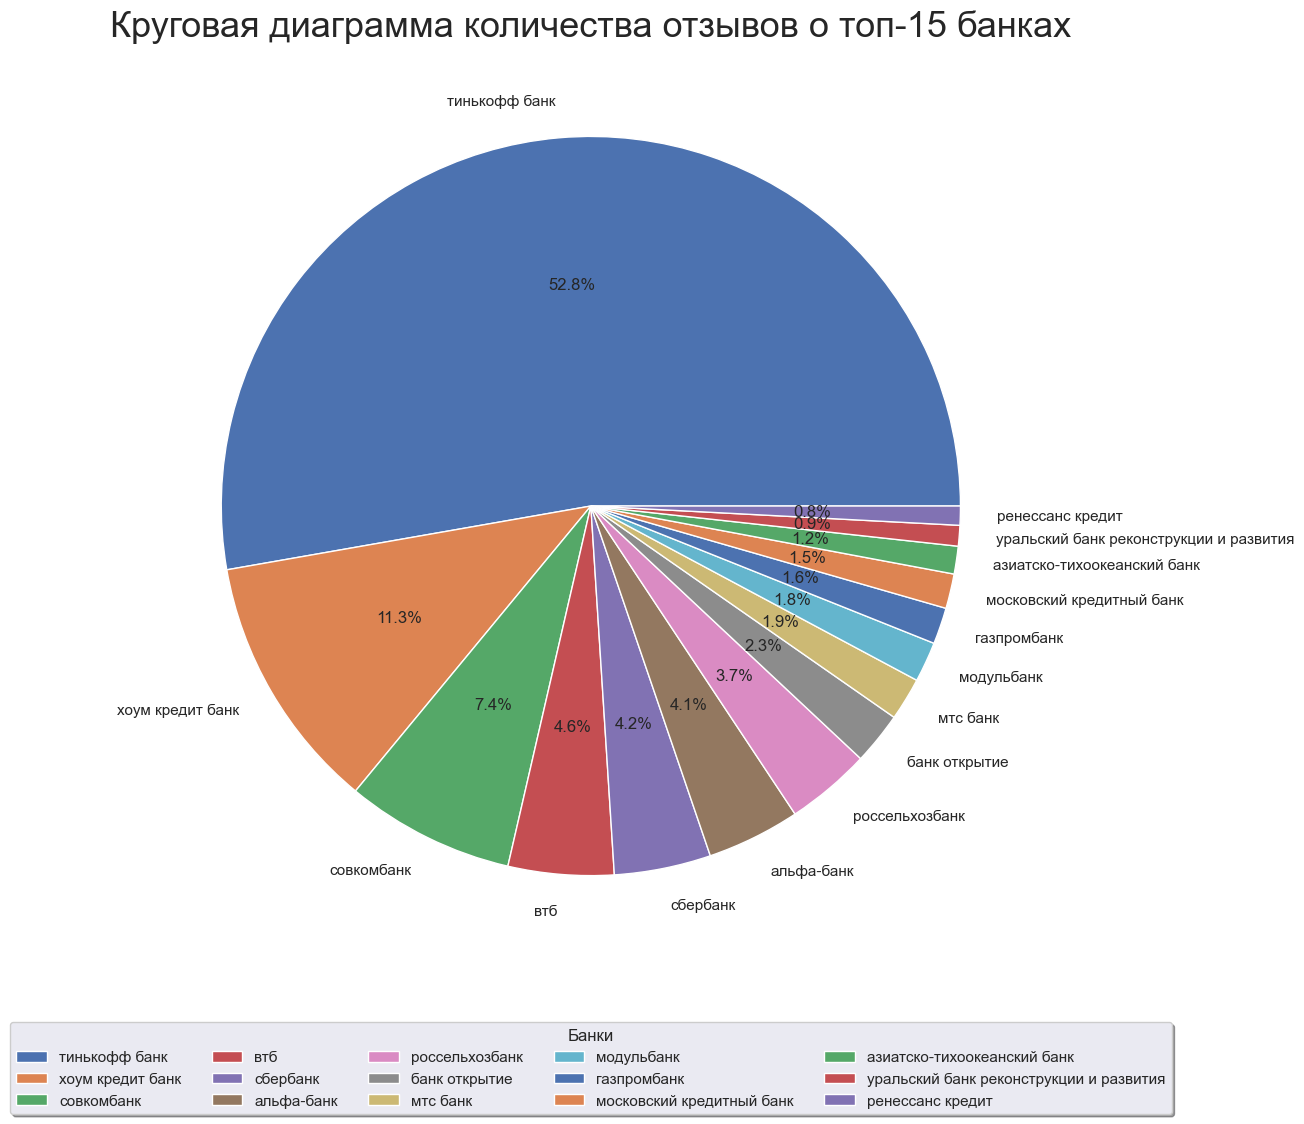

In [ ]:
plt.figure(figsize=(22,12))
plt.pie(top_15['cnt'], autopct="%.1f%%", labels = top_15['bank_name'])
plt.legend(top_15['bank_name'],
          title ="Банки",
          loc ="lower center",
          bbox_to_anchor =(1, 0, 0.5, 1), fontsize = 18)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, title="Банки")
plt.title("Круговая диаграмма количества отзывов о топ-15 банках", fontsize = 26);

### Какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?

In [ ]:
rtng = data.query('bank_name in @top_15.bank_name').groupby('bank_name')['rating'].mean().sort_values(ascending = False).reset_index().merge(top_15)
rtng

bank_name    rating    cnt
0                                модульбанк  4.778315   1448
1                             тинькофф банк  4.777977  43473
2               азиатско-тихоокеанский банк  4.718719    999
3                          хоум кредит банк  4.505555   9271
4                            россельхозбанк  4.455290   3053
5                                совкомбанк  4.263236   6082
6                 московский кредитный банк  4.240192   1249
7                             банк открытие  3.540784   1888
8   уральский банк реконструкции и развития  3.305108    744
9                                  мтс банк  2.901427   1542
10                                 сбербанк  2.306720   3482
11                              газпромбанк  2.147104   1312
12                                      втб  1.951117   3805
13                               альфа-банк  1.714668   3361
14                         ренессанс кредит  1.602041    686

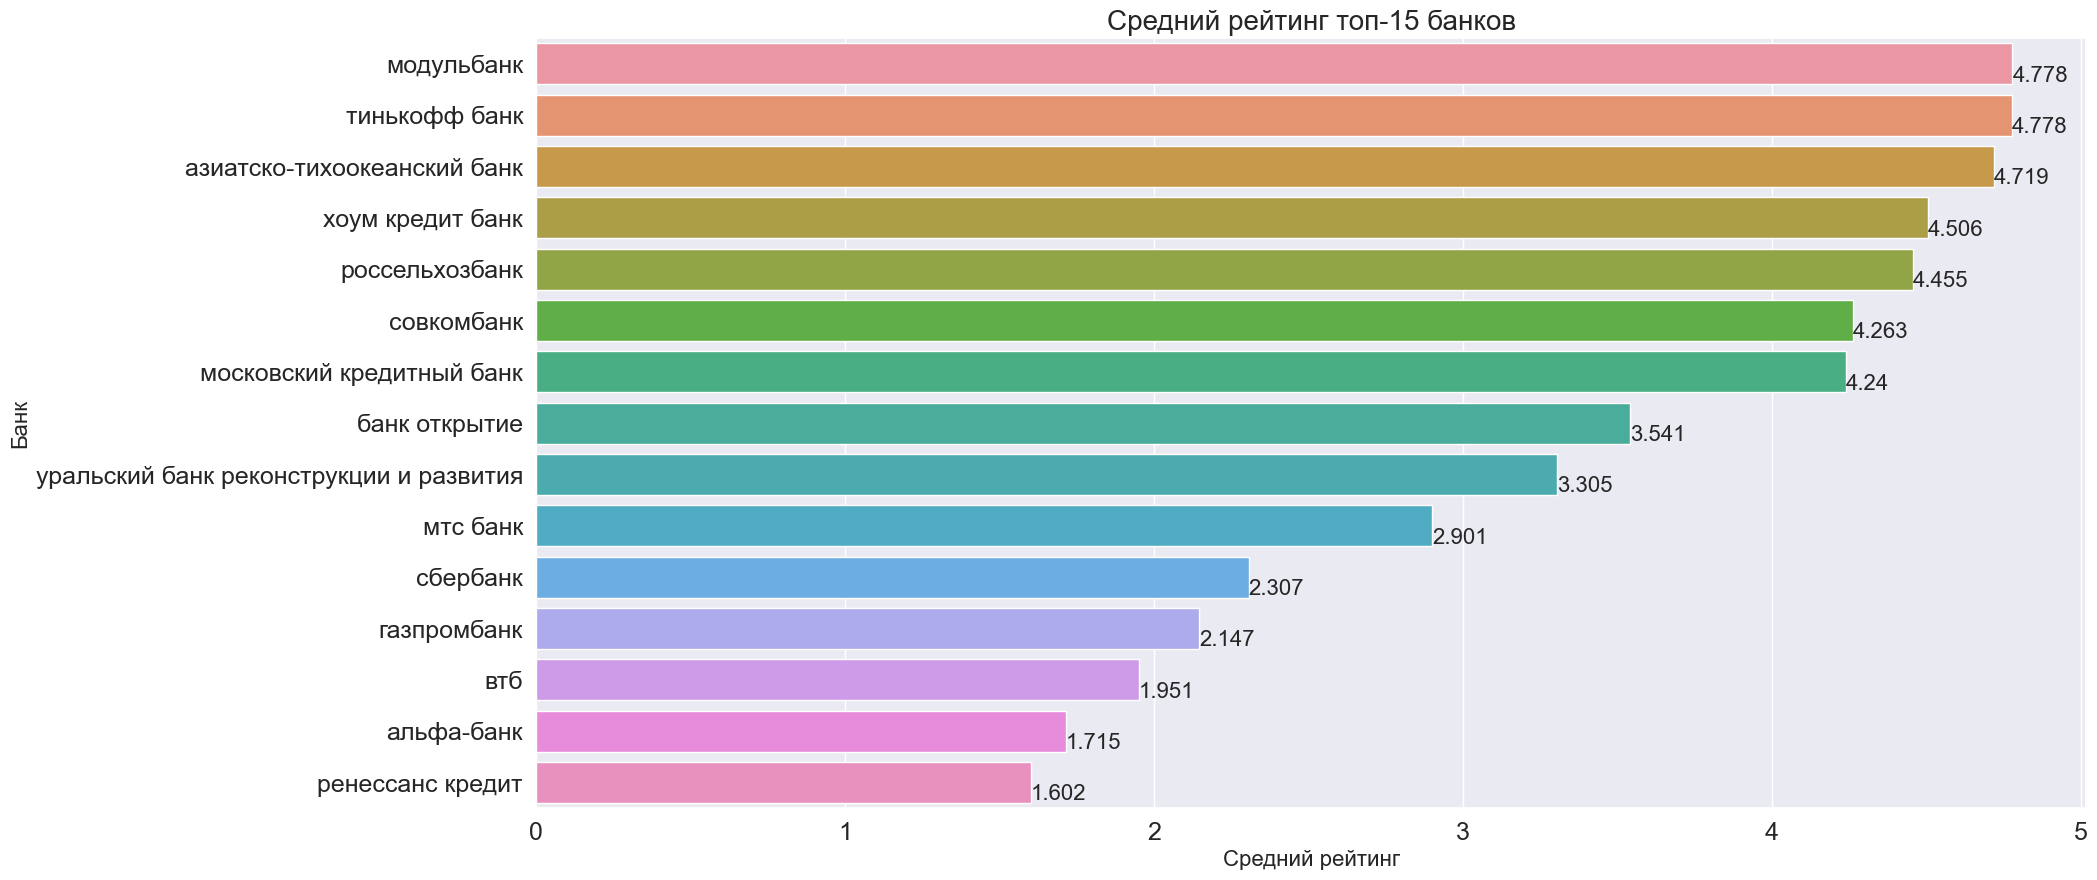

In [ ]:
ax = sns.barplot(y = rtng['bank_name'], x = rtng['rating'], orient = 'h')
for p in ax.patches:
    ax.annotate(f'{round(p.get_width(), 3)}', (p.get_x() + p.get_width(), p.get_y() + p.get_height()+0.1), 
                ha = 'left', va = 'center', xytext = (0, 10), textcoords = 'offset points', size = 16)
plt.title('Средний рейтинг топ-15 банков', fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('Банк', fontsize = 16)
plt.xlabel('Средний рейтинг', fontsize = 16);

### Сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов

In [ ]:
data['month_year'] = data['date'].dt.to_period('M')

In [ ]:
top_5 = data['bank_name'].value_counts().head(5).reset_index().rename(
    columns={'index': 'bank_name', 'bank_name': 'cnt'}).merge(data, how = 'left')
top_5

bank_name    cnt  \
0      тинькофф банк  43473   
1      тинькофф банк  43473   
2      тинькофф банк  43473   
3      тинькофф банк  43473   
4      тинькофф банк  43473   
...              ...    ...   
66108       сбербанк   3482   
66109       сбербанк   3482   
66110       сбербанк   3482   
66111       сбербанк   3482   
66112       сбербанк   3482   

                                                    body  \
0      при возврате просроченной задолженности банк з...   
1      новый год начинается с приятностей никогда не ...   
2      мне очень понравился тинькофф и как оформленно...   
3      в очередной раз убедился что тинькофф серьезны...   
4      от банка поступило предложение обновить услови...   
...                                                  ...   
66108  сентября г в сбербанк без какого либо предупре...   
66109  здравствуйте августа года обращалась в отделен...   
66110  сегодня пришла выплата детских пособий на карт...   
66111  августа года одобрено повышение лимита обещали...   
66112  подали заявление на субсидию тыс многодетным д...   

                                                   title  rating  \
0                     возврат просроченной задолженномти       1   
1                              клиентоориентиванность из       5   
2                                           хороший банк       5   
3                                 тинькофф всегда платит       5   
4                    высокое качество поддержки клиентов       5   
...                                                  ...     ...   
66108          угнали деньги со счета без предупреждения       1   
66109                                  обман потребителя       1   
66110  снимают деньги с детских пособий и говорят что...       1   
66111                  не предоставлено повышение лимита       2   
66112                               субсидия многодетным       1   

                     date month_year  
0     2023-01-03 12:31:46    2023-01  
1     2023-01-03 12:16:07    2023-01  
2     2023-01-03 11:58:32    2023-01  
3     2023-01-03 11:47:07    2023-01  
4     2023-01-03 11:40:05    2023-01  
...                   ...        ...  
66108 2022-09-02 12:44:42    2022-09  
66109 2022-09-02 12:37:52    2022-09  
66110 2022-09-02 12:17:15    2022-09  
66111 2022-09-02 12:16:43    2022-09  
66112 2022-09-02 11:49:06    2022-09  

[66113 rows x 7 columns]

In [ ]:
top_5.month_year = top_5.month_year.astype(str)

In [ ]:
top_5_plt = top_5.pivot_table(index = 'month_year', values = 'rating', columns = 'bank_name', aggfunc = 'mean')
top_5_plt.columns = top_5_plt.columns.values
top_5_plt

втб  сбербанк  совкомбанк  тинькофф банк  хоум кредит банк
month_year                                                                 
2022-09     2.073814  1.920000    3.882129       3.887314          4.058275
2022-10     1.914620  2.777547    3.847134       4.862005          3.591479
2022-11     1.994662  2.562708    4.230511       4.836923          4.001401
2022-12     1.897561  1.875252    4.523641       4.646044          4.626928
2023-01     1.148148  1.400000    4.379310       3.990291          2.833333

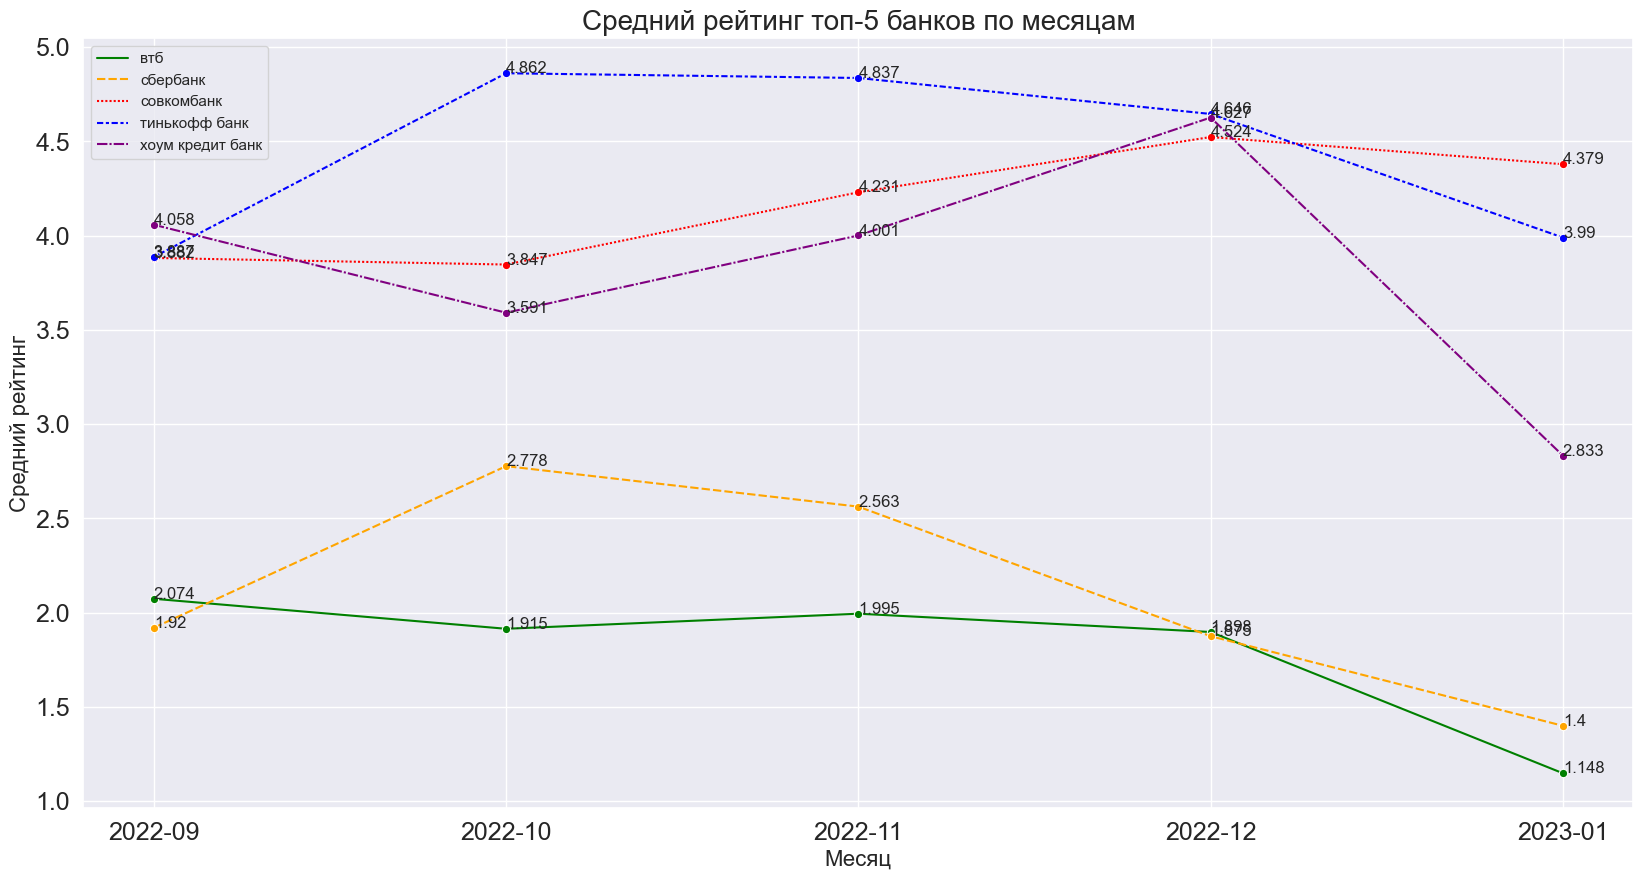

In [ ]:
plt.figure(figsize=(20,10))
palette = ["green","orange","red","blue", "purple"]
ax = sns.lineplot(data = top_5_plt, palette=palette, marker="o")
for i in range(0, len(top_5_plt)):
  for j in range(0, len(top_5_plt)):
    plt.text(top_5_plt.index[i], top_5_plt.values[i][j], f"{round(top_5_plt.values[i][j], 3)}")

plt.legend()
plt.title('Средний рейтинг топ-5 банков по месяцам', fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('Средний рейтинг', fontsize = 16)
plt.xlabel('Месяц', fontsize = 16);
plt.show()

In [ ]:
data = data.reset_index(drop = True)

### Поиск аномалий

Посмотрим гисторамму оценок

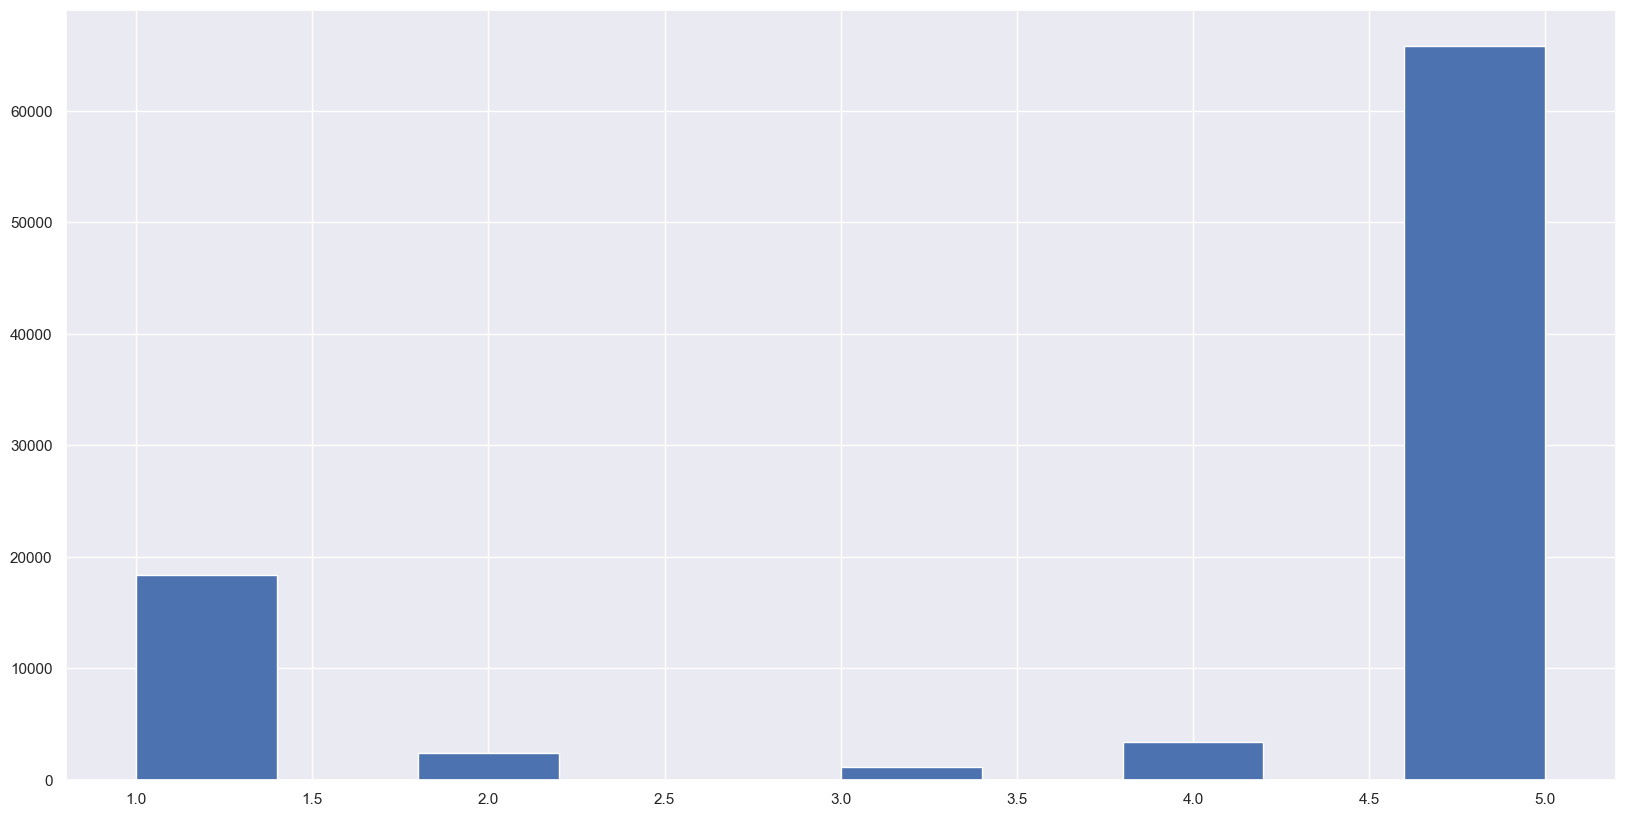

In [ ]:
data['rating'].hist(bins = 10);

Видим, что, в основном рейтинг отзывов в диапазон 4.6-5. Пользователи ставят либо очень низкие оценки, либо очень высокие, 2,3,4 почти не используются

Посмотрим, когда оставлено больше всего отзывов 

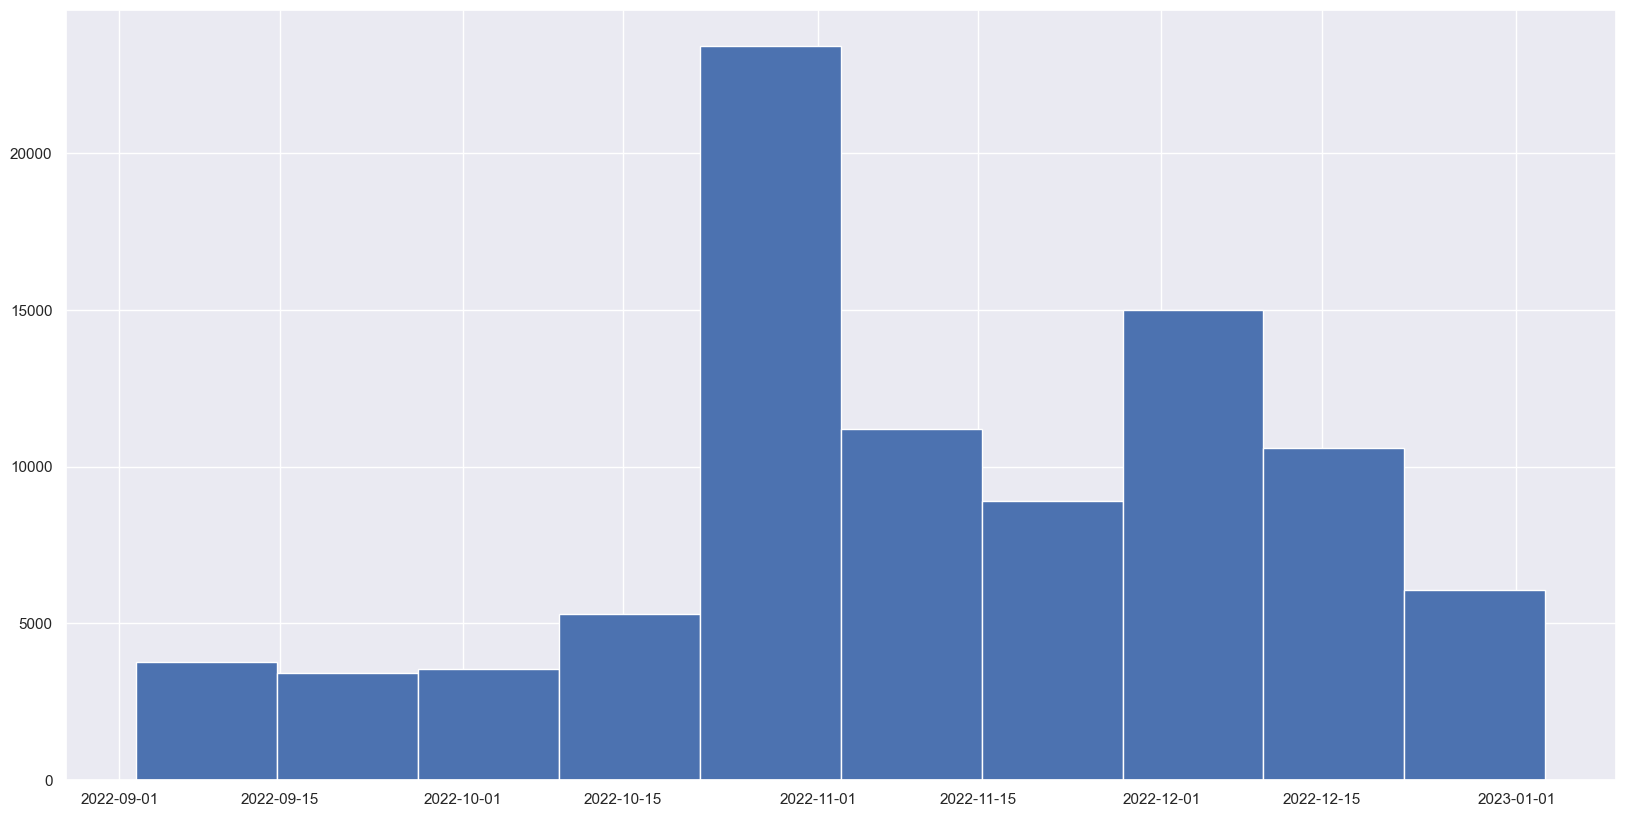

In [ ]:
data['date'].hist();

Посмотрим названия банков, которые присутствуют в датасете

In [ ]:
data['bank_name'].unique()

array(['еком банк', 'тинькофф банк', 'банк открытие', 'газпромбанк',
       'точка', 'втб', 'почта банк', 'хоум кредит банк', 'отп банк',
       'банк «санкт-петербург»', 'совкомбанк', 'альфа-банк', 'ак барс',
       'модульбанк', 'юникредит банк', 'россельхозбанк', 'сбербанк',
       'мтс банк', 'озон банк', 'александровский', 'ситибанк',
       'киви банк', 'росбанк', 'кредит европа банк', 'транскапиталбанк',
       'ренессанс кредит', 'райффайзен банк', 'юmoney', 'ббр банк',
       'московский кредитный банк',
       'всероссийский банк развития регионов', 'авангард',
       'азиатско-тихоокеанский банк', 'драйв клик банк', 'промсвязьбанк',
       'уральский банк реконструкции и развития', 'русский стандарт',
       'руснарбанк', 'юнистрим', 'абсолют банк', 'банк дом.рф',
       'бкс банк', 'банк зенит', 'банк уралсиб', 'кубань кредит',
       'локо-банк', 'татсоцбанк', 'финам банк', 'норвик банк',
       'банк синара (скб-банк)', 'экспобанк', 'хлынов', 'икано банк',
       'банк ак

Посмотрим заголовки отзывов

In [ ]:
data['title'].value_counts().head(10)

отличный банк               2231
благодарность               2199
отзыв                       1258
лучший банк                 1254
хороший банк                1183
дебетовая карта             1037
тинькофф                     527
кредитная карта              522
тинькофф банк                412
благодарность сотруднику     406
Name: title, dtype: int64

Рассмотрим дупликаты в отзывах

In [ ]:
dupl.groupby('bank_name')['body'].count().sort_values(ascending = False)

bank_name
тинькофф банк                              1391
хоум кредит банк                             39
совкомбанк                                   29
втб                                          12
модульбанк                                   12
россельхозбанк                               11
альфа-банк                                    8
сбербанк                                      8
банк открытие                                 6
юнистрим                                      4
цифра банк                                    4
росбанк                                       4
уральский банк реконструкции и развития       4
русский стандарт                              4
агророс                                       3
озон банк                                     2
газпромбанк                                   2
московский кредитный банк                     2
банк уралсиб                                  2
азиатско-тихоокеанский банк                   2
руснарбанк                    

Добавим в ДФ колонку с длиной отзыва

In [ ]:
lngth = []
for i in range(0,len(data['body'])):
    lngth.append(len(data['body'][i]))

In [ ]:
data['length'] = lngth

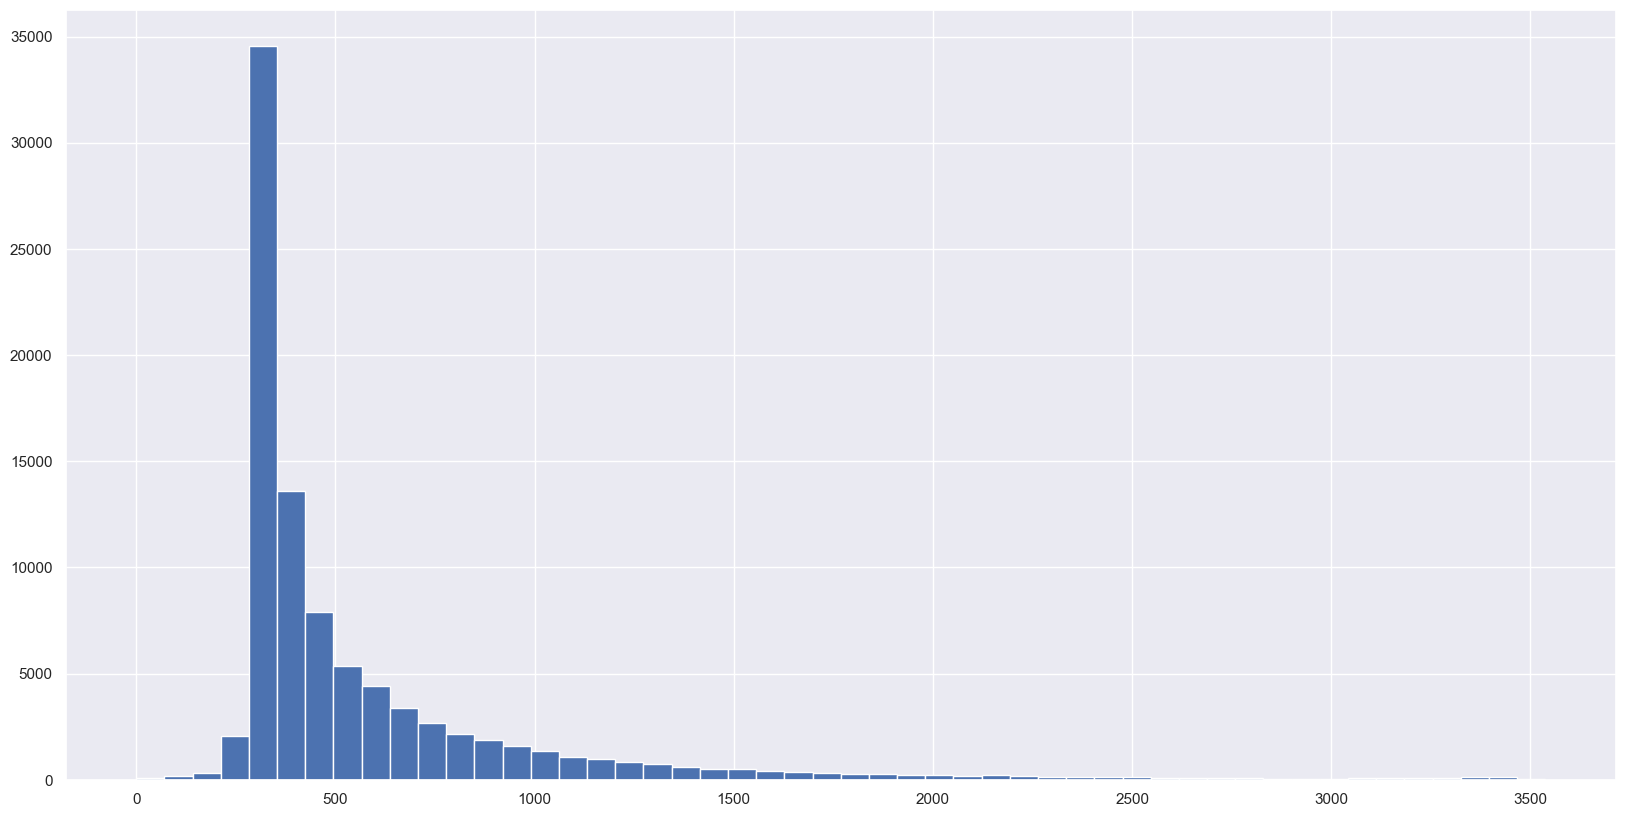

In [ ]:
data['length'].hist(bins = 50);

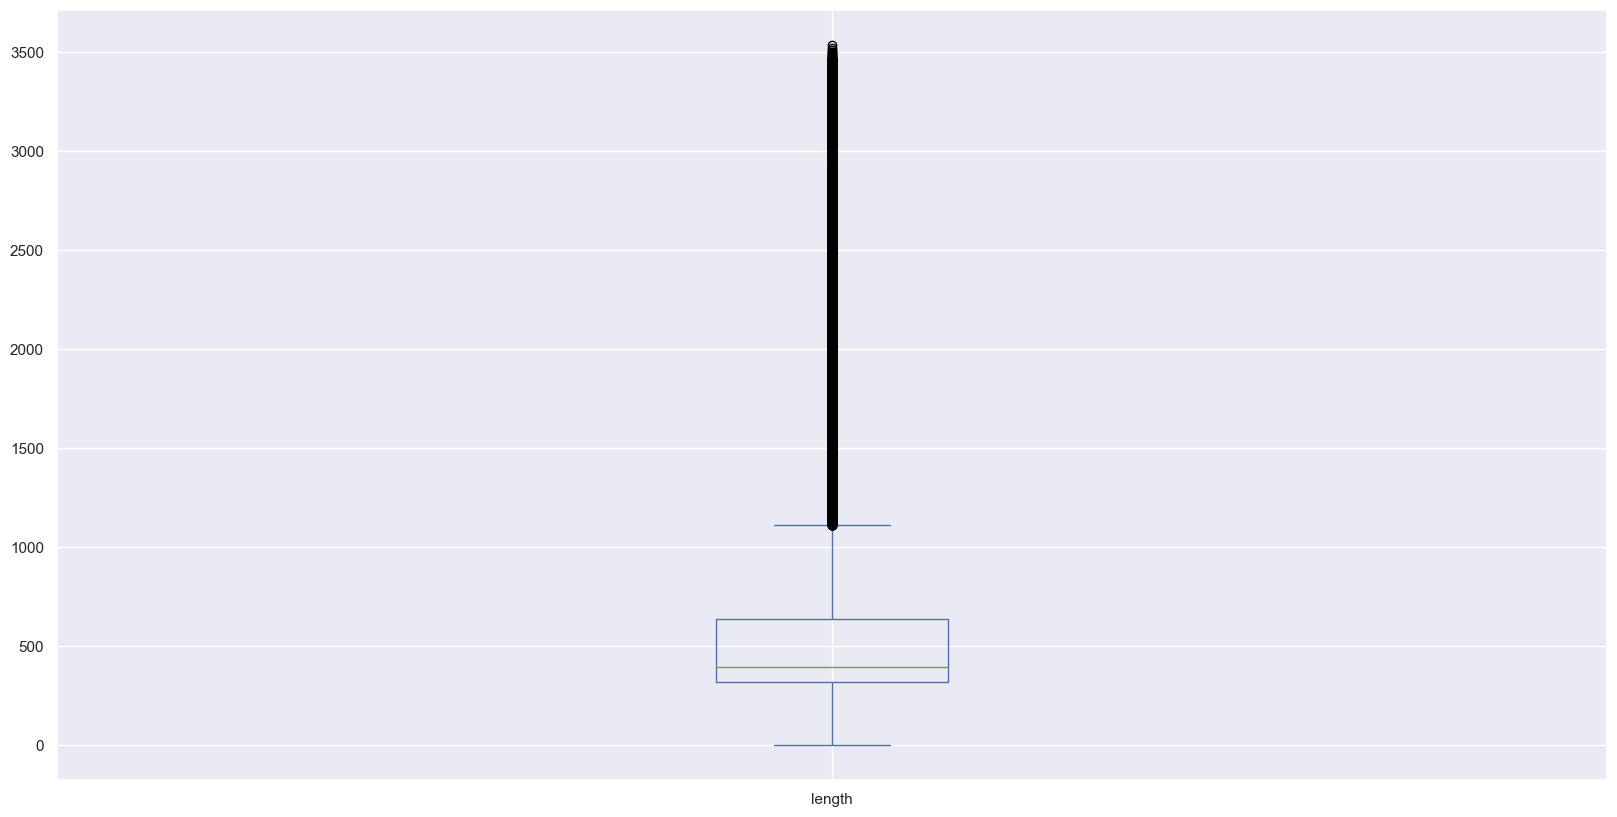

In [ ]:
data['length'].plot.box();

In [ ]:
print('Средняя длина отзыва:', int(data.length.mean()))

Средняя длина отзыва: 580


В основном длина отзыва 250-300 символов

Добавим колонку в ДФ, положительный ли отзыв или отрицательный, исходя из постановки задачи

In [ ]:
#Создадим функцию для создания колонки с категорией отзыва
def review(col):
  if 1 <= col <= 2:
    return 0
  else:
    return 1

In [ ]:
data['mark'] = data['rating'].apply(review)

In [ ]:
data.head()

body  \
0  добрый день пишу сюда для более скорого разреш...   
1  при возврате просроченной задолженности банк з...   
2  ю была оформлена кредитная карта дней в банке ...   
3  новый год начинается с приятностей никогда не ...   
4  увидела на сайте газпромбанка акцию с бонусом ...   

                                               title  rating      bank_name  \
0                             заблокировали средства       1      еком банк   
1                 возврат просроченной задолженномти       1  тинькофф банк   
2  ошибочное начисление комиссии затягивание проц...       1  банк открытие   
3                          клиентоориентиванность из       5  тинькофф банк   
4  как газпромбанк обманывает клиентов с акционны...       1    газпромбанк   

                 date month_year  length  mark  
0 2023-01-03 12:46:11    2023-01     463     0  
1 2023-01-03 12:31:46    2023-01     399     0  
2 2023-01-03 12:23:11    2023-01    1017     0  
3 2023-01-03 12:16:07    2023-01     841     1  
4 2023-01-03 12:12:36    2023-01     460     0

Посмотрим количество положительных и отрицательных отзывов

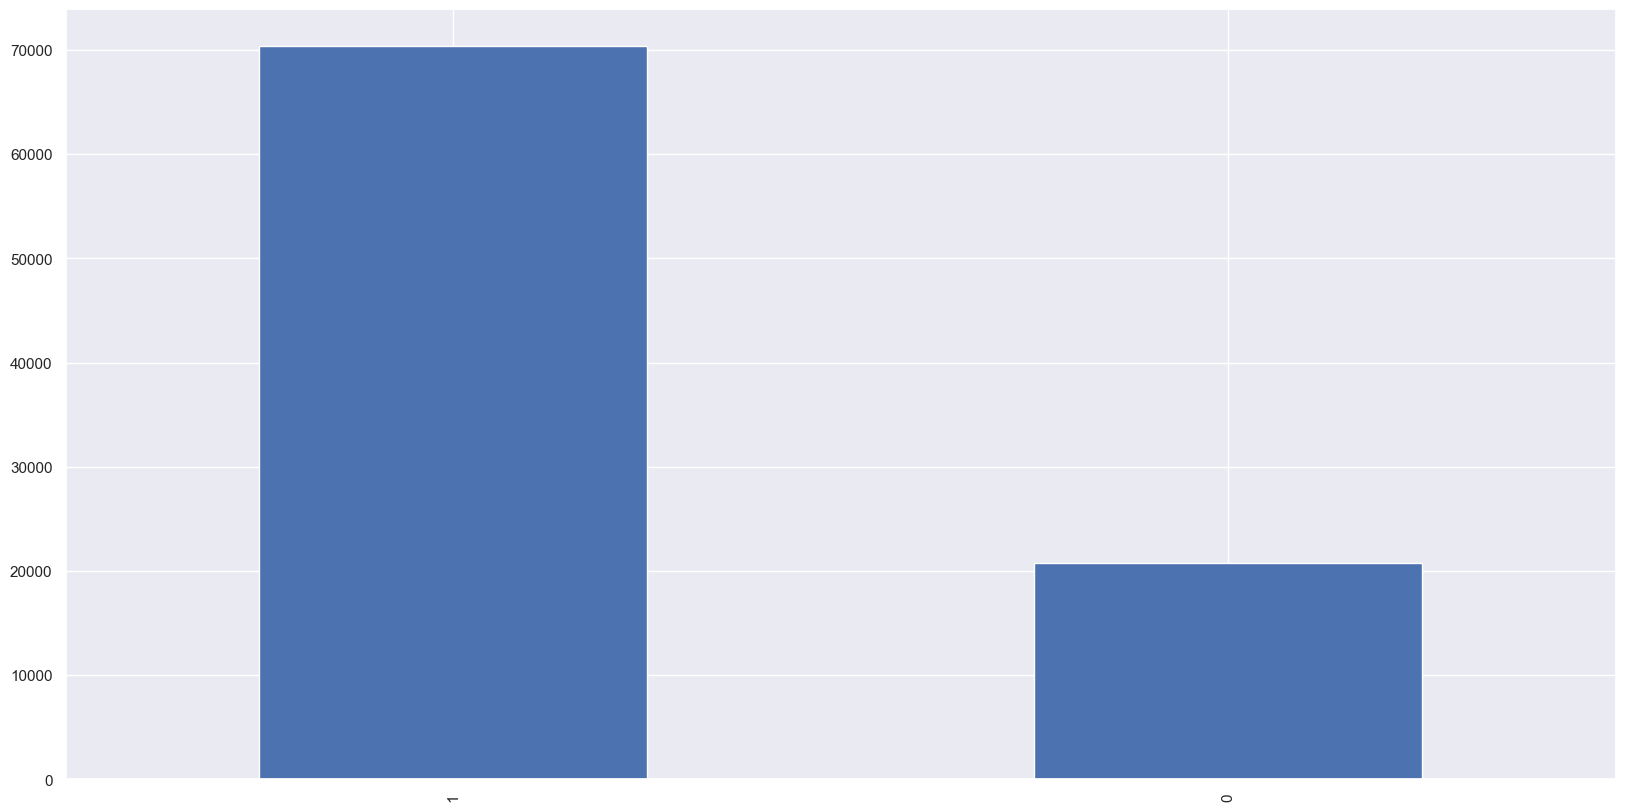

In [ ]:
data['mark'].value_counts().plot.bar();

Положительных отзывов в 3,5 раза больше, чем отрицательных

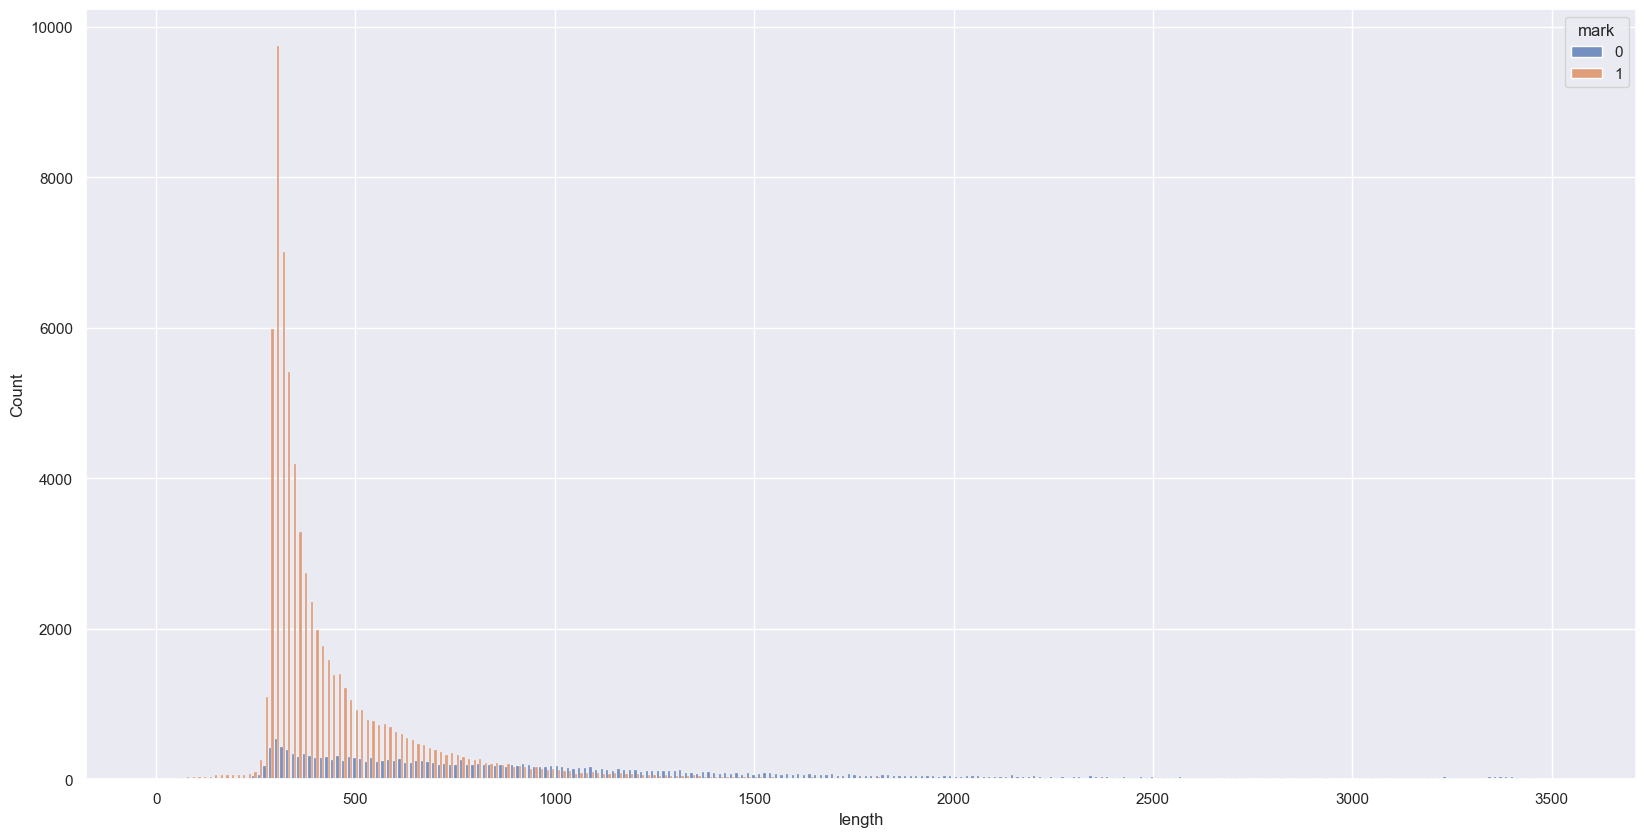

In [ ]:
sns.histplot(data=data, x="length", hue="mark", multiple="dodge", shrink=.8);

In [ ]:
top_15_mark = data.query('bank_name in @top_15.bank_name').groupby(['bank_name', 'mark'])['mark'].count().to_frame().rename(columns = {'mark' : 'cnt'}).reset_index()

In [ ]:
top_15_mark

bank_name  mark    cnt
0               азиатско-тихоокеанский банк     0     69
1               азиатско-тихоокеанский банк     1    930
2                                альфа-банк     0   2779
3                                альфа-банк     1    582
4                             банк открытие     0    664
5                             банк открытие     1   1224
6                                       втб     0   2901
7                                       втб     1    904
8                               газпромбанк     0    936
9                               газпромбанк     1    376
10                               модульбанк     0     64
11                               модульбанк     1   1384
12                московский кредитный банк     0    235
13                московский кредитный банк     1   1014
14                                 мтс банк     0    811
15                                 мтс банк     1    731
16                         ренессанс кредит     0    581
17                         ренессанс кредит     1    105
18                           россельхозбанк     0    420
19                           россельхозбанк     1   2633
20                                 сбербанк     0   2332
21                                 сбербанк     1   1150
22                               совкомбанк     0   1051
23                               совкомбанк     1   5031
24                            тинькофф банк     0   2147
25                            тинькофф банк     1  41326
26  уральский банк реконструкции и развития     0    299
27  уральский банк реконструкции и развития     1    445
28                         хоум кредит банк     0    679
29                         хоум кредит банк     1   8592

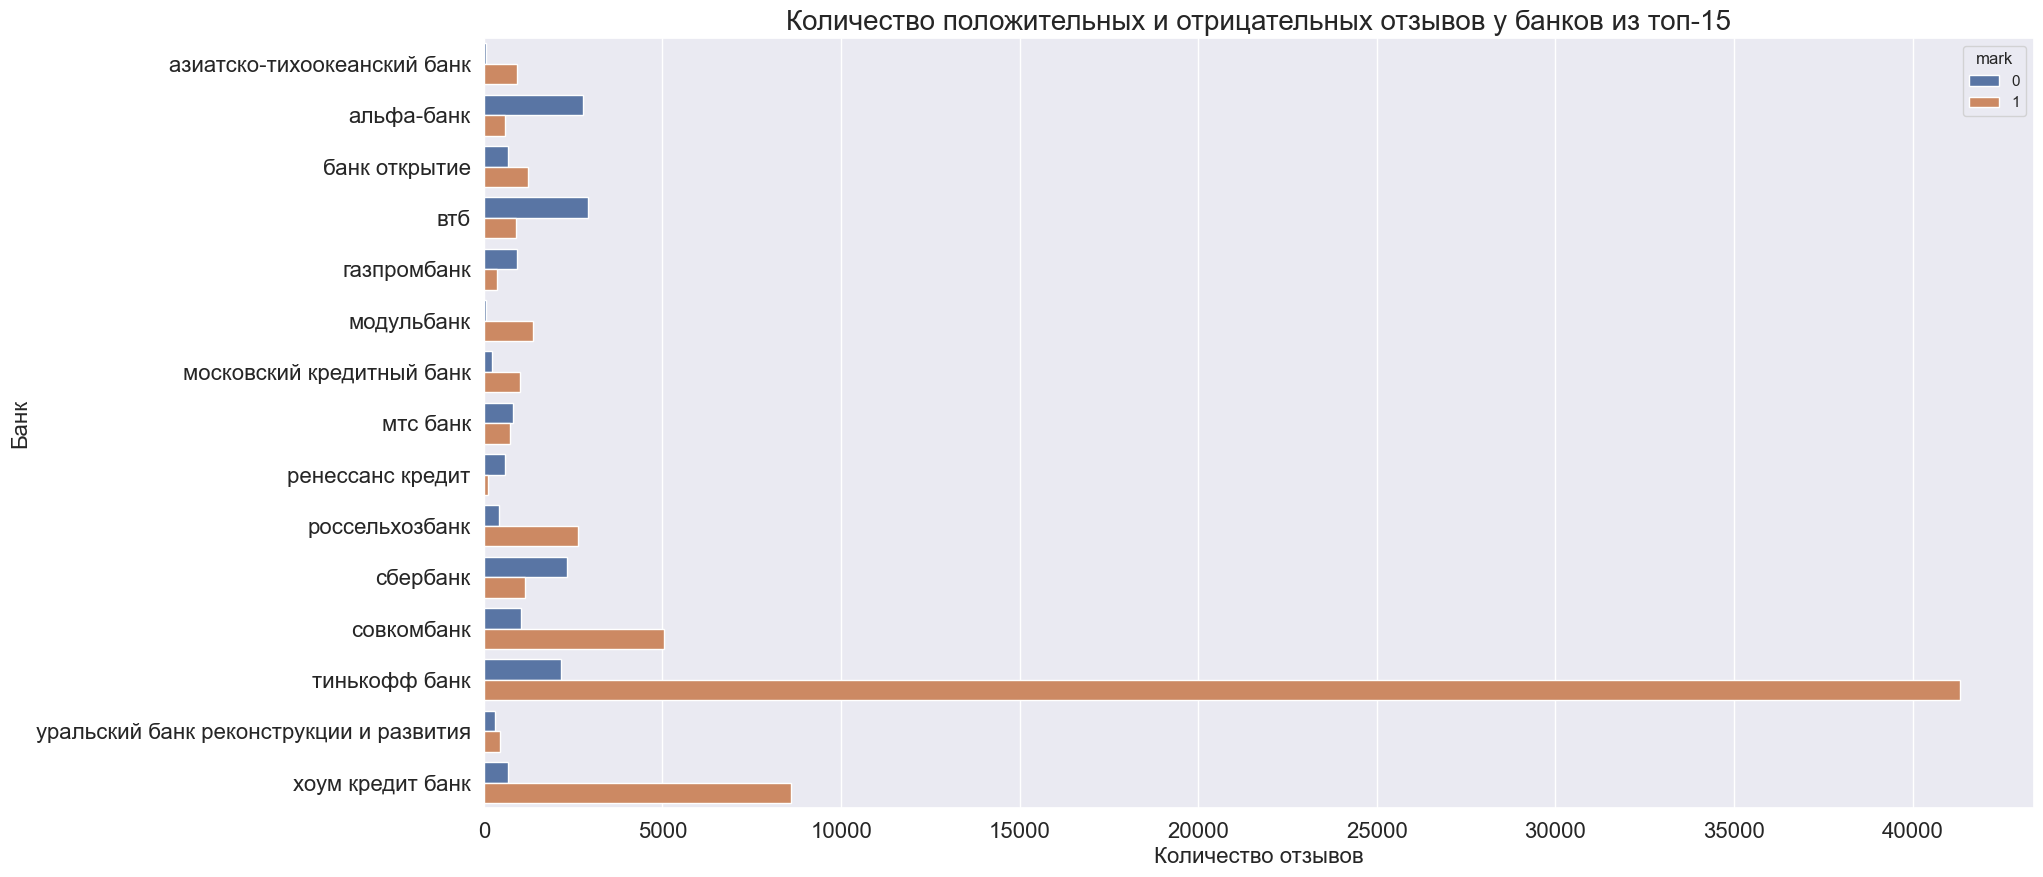

In [ ]:
sns.barplot(data = top_15_mark, y = top_15_mark.bank_name, x = top_15_mark.cnt, hue = top_15_mark.mark, orient = 'h')
plt.title('Количество положительных и отрицательных отзывов у банков из топ-15', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Количество отзывов', fontsize = 16)
plt.ylabel('Банк', fontsize = 16);

### Вывод

- топ-15 банков по числу отзывов:
  - 'тинькофф банк', 
  - 'хоум кредит банк', 
  - 'совкомбанк', 
  - 'втб',
  - 'сбербанк', 
  - 'альфа-банк', 
  - 'россельхозбанк', 
  - 'банк открытие',
  - 'мтс банк', 
  - 'модульбанк', 
  - 'газпромбанк',
  - 'московский кредитный банк', 
  - 'азиатско-тихоокеанский банк',
  - 'уральский банк реконструкции и развития', 
  - 'ренессанс кредит'

- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
  - с удалением дупликатов отзывов: модульбанк, без удаления: тинькофф банк

- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
  - в декабре и январе средний рейтинг всех банков из топ-5 снизился
- нет ли в данных в целом каких-то странностей на ваш взгляд?
  - очень много отзывов по банку тинькофф
  - дупликаты отзывов
  - странные отзывы
  - возможно, есть несуществующие названия банков
  - большое количество отзывов в начале ноября
  - большое количество дупликатов отзывов о тинькофф банк


Уберем из данных лишние столбцы

## 3. Создание моделей

In [ ]:
new_df = data.copy()

In [ ]:
new_df = new_df.drop(['rating', 'bank_name', 'date', 'month_year', 'length'], axis = 1)

In [ ]:
new_df.head()

body  \
0  добрый день пишу сюда для более скорого разреш...   
1  при возврате просроченной задолженности банк з...   
2  ю была оформлена кредитная карта дней в банке ...   
3  новый год начинается с приятностей никогда не ...   
4  увидела на сайте газпромбанка акцию с бонусом ...   

                                               title  mark  
0                             заблокировали средства     0  
1                 возврат просроченной задолженномти     0  
2  ошибочное начисление комиссии затягивание проц...     0  
3                          клиентоориентиванность из     1  
4  как газпромбанк обманывает клиентов с акционны...     0

In [ ]:
stop_words = set(stopwords.words('russian'))

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def predproc(text):
    token = nltk.word_tokenize(text)
    text = [word for word in token if word not in stop_words]
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

In [ ]:
new_df['predproc'] = new_df['body'].apply(predproc)

In [ ]:
y = new_df['mark']
dataset = new_df.drop(['mark', 'body', 'title'], axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.25, random_state=100, stratify = y)

In [ ]:
print('Train data shape:', X_train.shape, y_train.shape)
print('Test data shape:', X_test.shape, y_test.shape)

Train data shape: (68380, 1) (68380,)
Test data shape: (22794, 1) (22794,)


Создадим функцию обучения моделей

In [ ]:
def training(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df = 1)),
        ('model', model)])
    grid = GridSearchCV(pipeline, cv = 5, n_jobs = -1, param_grid = params ,scoring = 'f1', verbose = False)
    grid.fit(X_train['predproc'], y_train)
    print('Лучший результат:', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    return grid

In [ ]:
lr_mod = training(LogisticRegression(class_weight="balanced", random_state = 100), {"model__C":[0.1, 1.0, 10.0], "model__penalty":["l2"]})

Лучший результат: 0.9792110383037336
Лучшие параметры: {'model__C': 10.0, 'model__penalty': 'l2'}


In [ ]:
dtc_mod = training(DecisionTreeClassifier(class_weight='balanced', random_state = 100), {'model__criterion':['gini','entropy'],'model__max_depth':[2,4,6]})

Лучший результат: 0.8894026791013852
Лучшие параметры: {'model__criterion': 'gini', 'model__max_depth': 6}


In [ ]:
cat_mod = training(CatBoostClassifier(logging_level='Silent', class_weights = (4, 1)), {'model__depth': [4,6],
                 'model__learning_rate' : [0.01,0.03],
                  'model__iterations' : [10, 50]})

Лучший результат: 0.8978738460182172
Лучшие параметры: {'model__depth': 6, 'model__iterations': 50, 'model__learning_rate': 0.03}


Лучшие показатели на трейне у логистической регрессии, поэтому в тестировании будем использовать её

In [ ]:
pred = lr_mod.predict(X_test['predproc'])

In [ ]:
res = f1_score(y_test, pred)

In [ ]:
print("Результат LogisticRegression", res)

Результат LogisticRegression 0.9803944082441083


## 4. Интерпретация модели и метрики

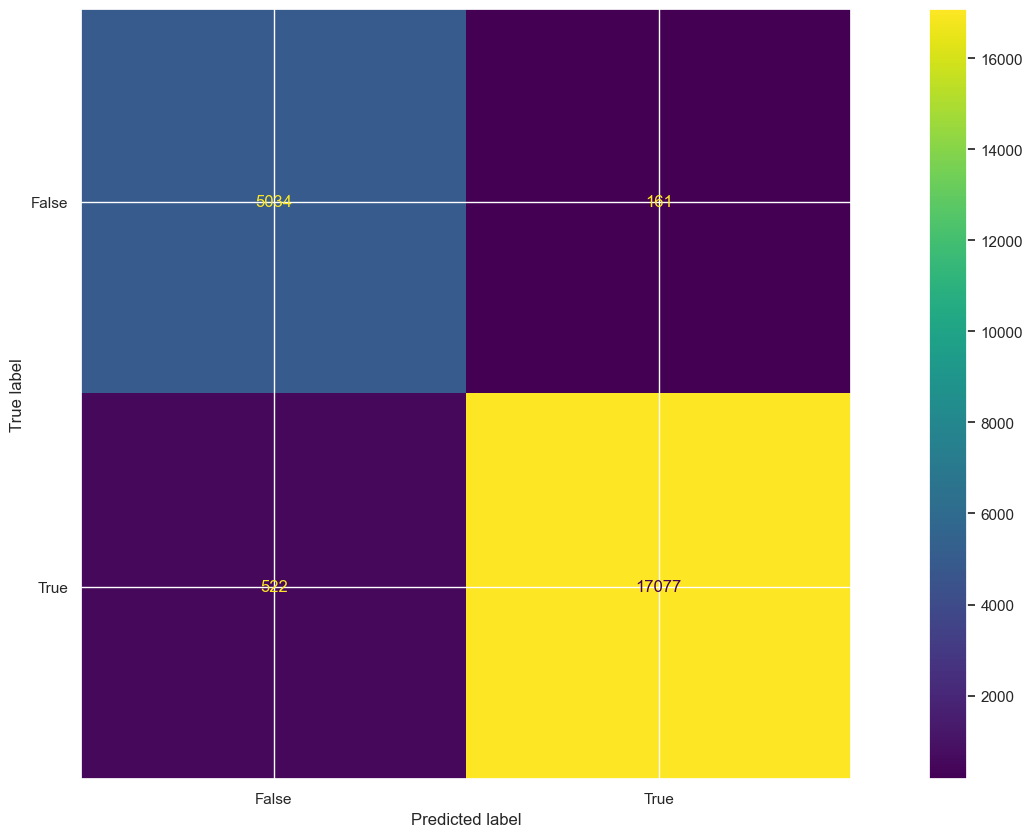

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
target_names = ['Negative', 'Positive']
print(classification_report(y_test, pred, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.91      0.97      0.94      5195
    Positive       0.99      0.97      0.98     17599

    accuracy                           0.97     22794
   macro avg       0.95      0.97      0.96     22794
weighted avg       0.97      0.97      0.97     22794



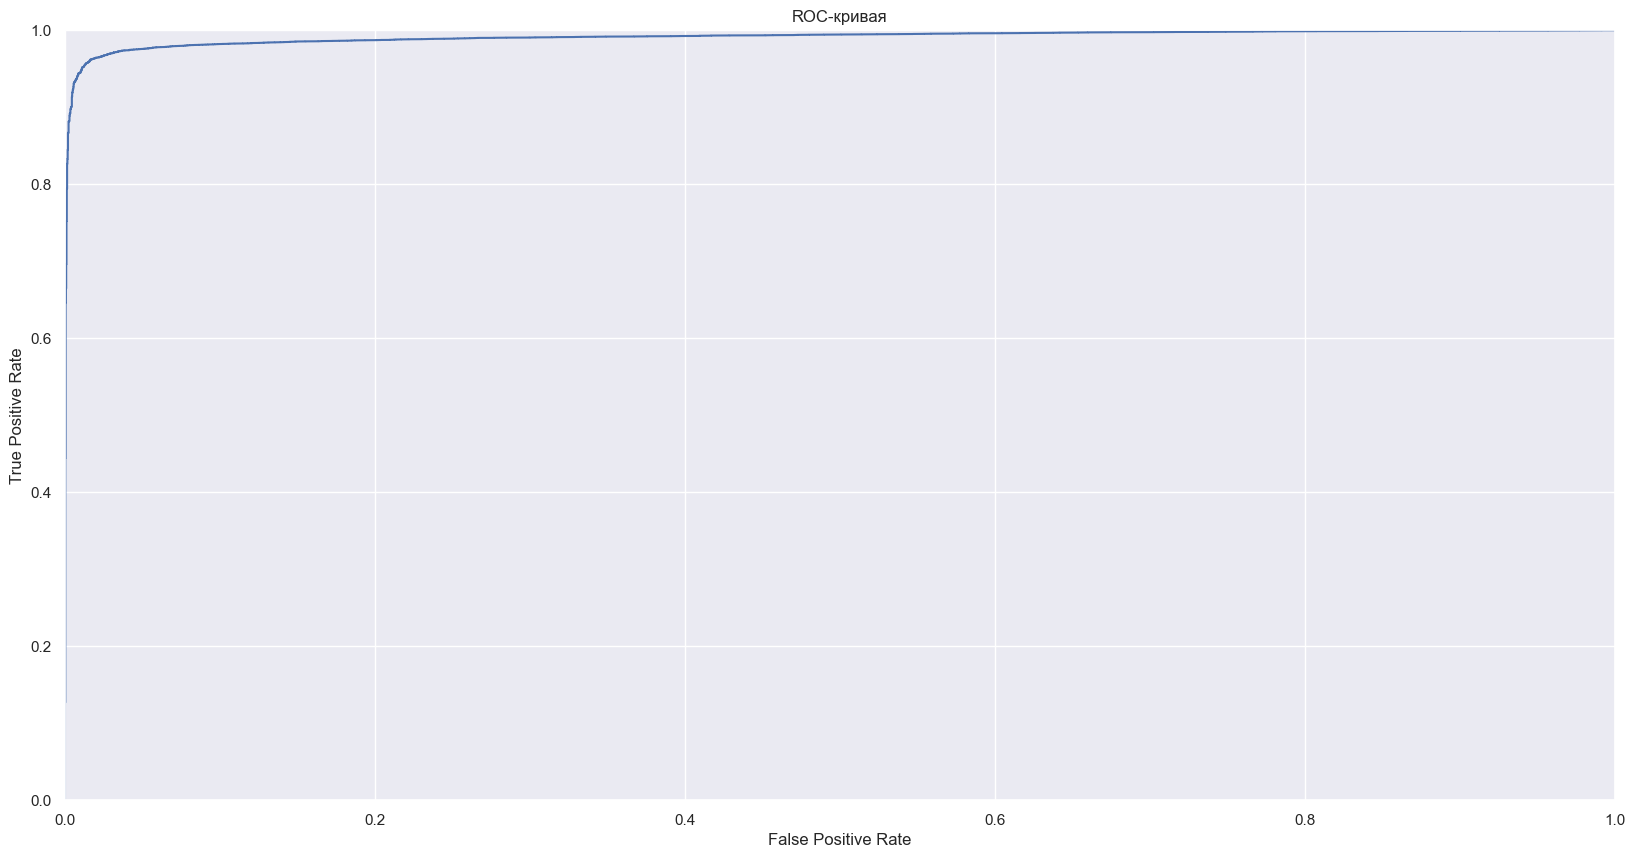

Показатели roc auc: 0.9912267961239595


In [ ]:
probabilities_test = lr_mod.predict_proba(X_test['predproc'])
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print('Показатели roc auc:', auc_roc)

In [ ]:
vectorizer = TfidfVectorizer(min_df=10)
X_train_vect = vectorizer.fit_transform(X_train['predproc']).toarray() # sparse also works but Explanation slicing is not yet supported
X_test_vect = vectorizer.transform(X_test['predproc']).toarray()

In [ ]:
model = LogisticRegression(penalty=lr_mod.best_params_['model__penalty'], C=lr_mod.best_params_['model__C'], random_state = 100)
model.fit(X_train_vect, y_train)

LogisticRegression(C=10.0, random_state=100)

In [ ]:
explainer = shap.Explainer(model, X_train_vect, feature_names = vectorizer.get_feature_names())
shap_values = explainer(X_test_vect)

Linear explainer: 22795it [01:05, 305.41it/s]                                                                          


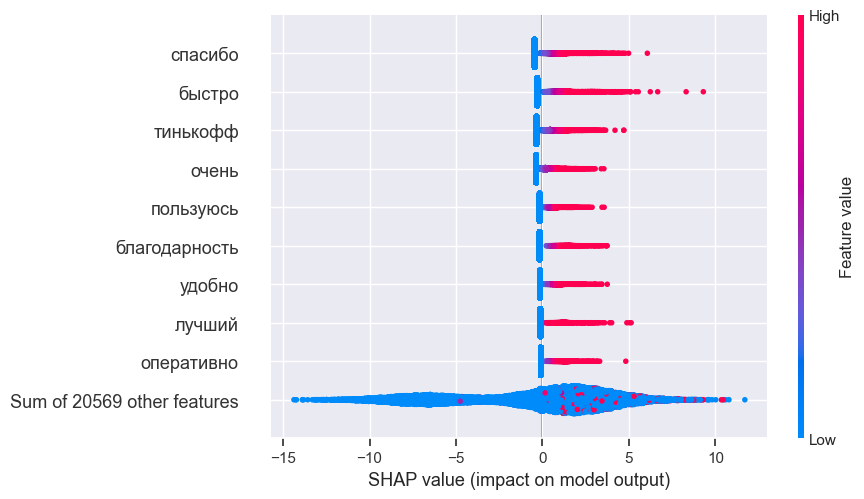

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
ind = 0
shap.plots.force(shap_values[ind])

In [ ]:
print("Положительный" if y_test.iloc[ind] else "Негативный", "Отзыв:")
print(X_test['predproc'].iloc[ind])

Положительный Отзыв:
банном отзыве хочется рассказать обо особенностях поддержки банка тинькофф поддержка операторы чате очень отзывчивые помогут решить практичкски любую проблему могут спеть вами песню онлайн чате недавно просходил конфликт сервисом доставки менеджеры чате решили вопрос макаиммально быстро оставили ответа


In [ ]:
ind = 1
shap.plots.force(shap_values[ind])

In [ ]:
print("Положительный" if y_test.iloc[ind] else "Негативный", "Отзыв:")
print(X_test['predproc'].iloc[ind])

Негативный Отзыв:
обратил внимание схожих отзывов видимо банк решил подзаработать конец года едемесячно погашаю ипотеку частично досрочным погашением ноябре подал заявку мобильном приложении частичного досрочного погашения это делал предыдущих месяцах итоге плановая сумма списалась сумма чдп банк поменял метод списания нужно подать заявку сумму чдп ранее указывал полную сумму плановым платежом итоге начислили проценты рассматривают мое обращение рассматриваю это обман стороны банка обращение


## 5. Вывод
- топ-15 банков по числу отзывов:
  - 'тинькофф банк', 
  - 'хоум кредит банк', 
  - 'совкомбанк', 
  - 'втб',
  - 'сбербанк', 
  - 'альфа-банк', 
  - 'россельхозбанк', 
  - 'банк открытие',
  - 'мтс банк', 
  - 'модульбанк', 
  - 'газпромбанк',
  - 'московский кредитный банк', 
  - 'азиатско-тихоокеанский банк',
  - 'уральский банк реконструкции и развития', 
  - 'ренессанс кредит'

- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
  - с удалением дупликатов отзывов: модульбанк, без удаления: тинькофф банк

- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
  - в декабре и январе средний рейтинг всех банков из топ-5 снизился
- нет ли в данных в целом каких-то странностей на ваш взгляд?
  - очень много отзывов по банку тинькофф
  - дупликаты отзывов
  - странные отзывы
  - возможно, есть несуществующие названия банков
  - большое количество отзывов в начале ноября
  - большое количество дупликатов отзывов о тинькофф банк
- Самая лучшая модель получилась Logistic Regression с метрикой f1 ~ 0.98 на валидационной выборке
- Построенная модель определяет, положительный ли отзыв или отрицательный
- Приведена интерпретация работы модели